#### Cumulative Reward Comparison

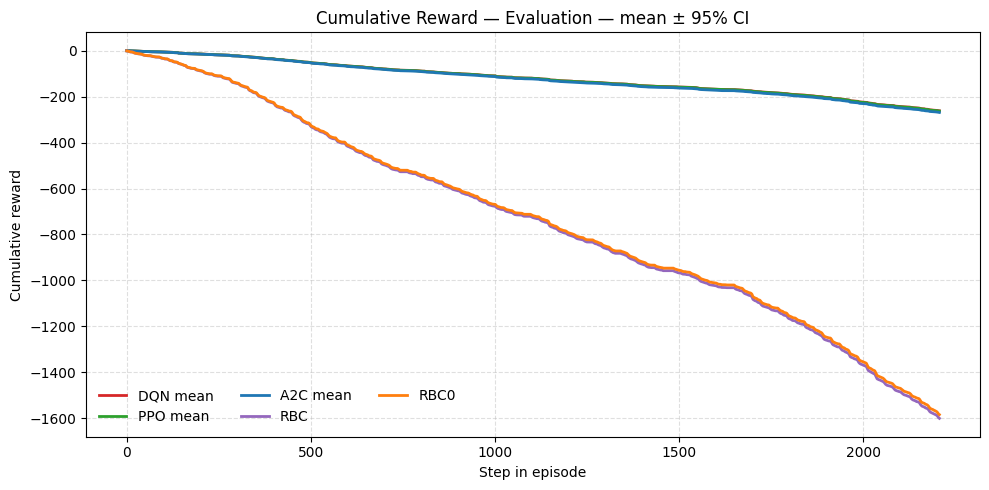

/scratch/slurm_tmpdir/job_1547148/ipykernel_584110/3236858549.py:119: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data, labels=labels, showfliers=False, patch_artist=True)


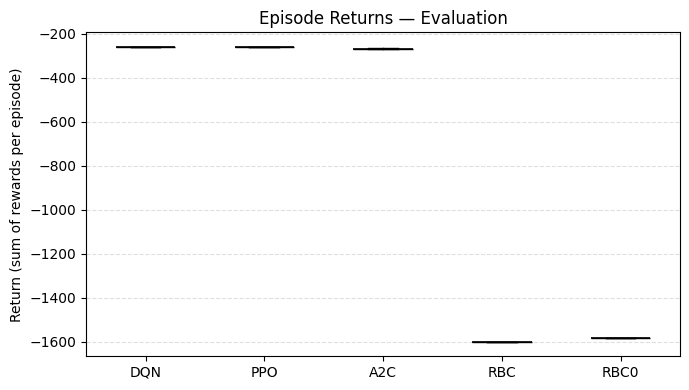

DQN  : mean=-261.59, std=0.00, n=10
PPO  : mean=-262.70, std=0.00, n=10
A2C  : mean=-268.85, std=0.65, n=10
RBC  : mean=-1600.19, std=0.00, n=10
RBC0 : mean=-1584.09, std=0.00, n=10


/scratch/slurm_tmpdir/job_1547148/ipykernel_584110/3236858549.py:193: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels, showfliers=False)


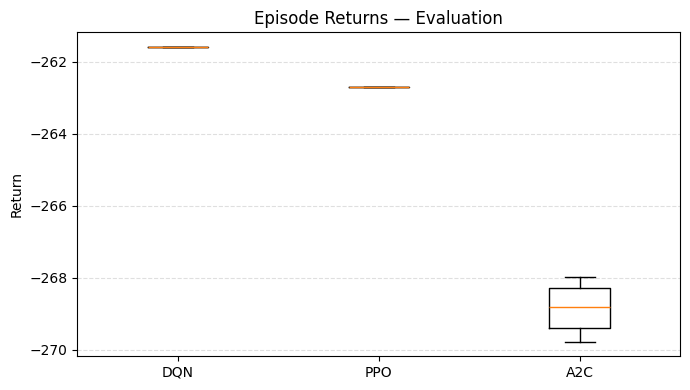

DQN: mean=-261.59 ± 0.00 (n=10)
PPO: mean=-262.70 ± 0.00 (n=10)
A2C: mean=-268.85 ± 0.65 (n=10)


In [1]:
import os, pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# ---- Pfade (aus deinem Setup) ----
DQN_EVAL_FILE  = r'/hkfs/home/haicore/iai/cj9272/logs/dqn/dqn_eval_10episodes_1seed.pkl'
PPO_EVAL_FILE  = r'/hkfs/home/haicore/iai/cj9272/logs/ppo/ppo_eval_10episodes_1seed.pkl'
A2C_EVAL_FILE  = r'/hkfs/home/haicore/iai/cj9272/logs/a2c/a2c_eval_10episodes_1seed.pkl'
RBC_LOG_FILE   = r'/hkfs/home/haicore/iai/cj9272/logs/rbc/rbc_agent_logs_10episodes.csv'
RBC0_LOG_FILE  = r'/hkfs/home/haicore/iai/cj9272/logs/rbc0/rbc0_agent_logs_10episodes.csv'

COLOR = {"DQN":"C3","PPO":"C2","A2C":"C0","RBC":"C4","RBC0":"C1"}

# ---------- Loader ----------
def _to1f(x): return np.asarray(x, float).ravel()

def all_episode_step_rewards_from_pkl(path):
    """Gibt Liste[np.ndarray] der per-step Rewards je Episode zurück."""
    with open(path, "rb") as f:
        d = pickle.load(f)
    if isinstance(d, dict):
        if "ep_rewards_list" in d:
            ep = d["ep_rewards_list"]
            if len(ep) and isinstance(ep[0], (list, tuple, np.ndarray)):
                return [ _to1f(e) for e in ep ]
            else:
                # ep_rewards_list enthält schon Episode-Returns -> als 1-Step-Episoden verpacken
                return [ _to1f([v]) for v in _to1f(d["ep_rewards_list"]) ]
        if "step_rewards" in d and "ep_lengths" in d:
            steps = _to1f(d["step_rewards"]); lens = np.asarray(d["ep_lengths"], int).ravel()
            offs = np.cumsum(np.concatenate([[0], lens[:-1]]))
            return [ steps[o:o+l] for o,l in zip(offs, lens) ]
    raise ValueError(f"Unbekanntes Format: {path}")

def all_episode_step_rewards_from_csv(path):
    """RBC/RBC0 CSV -> Liste per-step Rewards pro Episode."""
    df = pd.read_csv(path)
    if 'episode' not in df.columns or 'reward' not in df.columns:
        raise KeyError("CSV braucht 'episode' und 'reward'.")
    df = df.sort_values(['episode', 'timestep' if 'timestep' in df.columns else df.index.name or df.index]).reset_index(drop=True)
    out = []
    for ep, grp in df.groupby('episode'):
        out.append(grp['reward'].to_numpy(float))
    return out

def mean_ci_cumcurves(list_of_step_rewards):
    """Gleicht Länge an (min), berechnet mean & 95% CI der kum. Rewards."""
    if not list_of_step_rewards:
        return None
    L = min(len(r) for r in list_of_step_rewards)
    M = np.vstack([np.cumsum(r[:L]) for r in list_of_step_rewards])
    mean = M.mean(axis=0)
    sem  = M.std(axis=0, ddof=1) / np.sqrt(M.shape[0]) if M.shape[0] > 1 else np.zeros_like(mean)
    ci95 = 1.96 * sem
    return mean, ci95

def episode_returns(list_of_step_rewards):
    return np.array([np.sum(r) for r in list_of_step_rewards], float)

# ---------- Daten laden ----------
sources = {
    "DQN":  ("pkl", DQN_EVAL_FILE),
    "PPO":  ("pkl", PPO_EVAL_FILE),
    "A2C":  ("pkl", A2C_EVAL_FILE),
    "RBC":  ("csv", RBC_LOG_FILE),
    "RBC0": ("csv", RBC0_LOG_FILE),
}
curves = {}   # name -> (mean, ci)  oder (line, None) falls nur eine Episode
returns = {}  # name -> np.array per-episode returns

for name, (kind, path) in sources.items():
    if not Path(path).exists():
        print(f"[Warn] fehlt: {name} -> {path}"); continue
    if kind == "pkl":
        eps = all_episode_step_rewards_from_pkl(path)
    else:
        eps = all_episode_step_rewards_from_csv(path)
    returns[name] = episode_returns(eps)
    mc = mean_ci_cumcurves(eps)
    if mc is None: 
        continue
    mean, ci = mc
    curves[name] = (mean, ci if len(eps) > 1 else None)

# ---------- FIGURE 1: Cumulative Reward (mean ± 95% CI) ----------
plt.figure(figsize=(10,5))
for name in ["DQN","PPO","A2C"]:
    if name in curves:
        mean, ci = curves[name]
        x = np.arange(len(mean))
        plt.plot(x, mean, lw=2, label=f"{name} mean", color=COLOR[name])
        if ci is not None and np.any(ci):
            plt.fill_between(x, mean-ci, mean+ci, alpha=0.15, linewidth=0, color=COLOR[name])

# RBC/RBC0 als Einzellinien (falls mehrere Episoden vorhanden, zeigen wir nur den Mean ohne Band – sonst erschlägt’s)
for name in ["RBC","RBC0"]:
    if name in curves:
        mean, ci = curves[name]
        x = np.arange(len(mean))
        plt.plot(x, mean, lw=2, label=name, color=COLOR[name], linestyle='-')

plt.xlabel("Step in episode")
plt.ylabel("Cumulative reward")
plt.title("Cumulative Reward — Evaluation — mean ± 95% CI")
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend(frameon=False, ncol=3)
plt.tight_layout()
plt.show()

# ---------- FIGURE 2: Episode Returns (Boxplot) ----------
data, labels, colors = [], [], []
for name in ["DQN","PPO","A2C","RBC","RBC0"]:
    if name in returns and returns[name].size:
        data.append(returns[name]); labels.append(name); colors.append(COLOR[name])

fig, ax = plt.subplots(figsize=(7,4))
bp = ax.boxplot(data, labels=labels, showfliers=False, patch_artist=True)
for patch, c in zip(bp['boxes'], colors):
    patch.set_facecolor(plt.rcParams['axes.prop_cycle'].by_key()['color'][int(COLOR[name][1]) % 10] if c.startswith('C') else c)
# Median-Linie dunkler
for med in bp['medians']: med.set_color('black'); med.set_linewidth(1.2)

ax.set_title("Episode Returns — Evaluation")
ax.set_ylabel("Return (sum of rewards per episode)")
ax.grid(True, axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

# Optional: Zahlen drucken
for name in labels:
    r = returns[name]
    print(f"{name:5s}: mean={r.mean():.2f}, std={r.std(ddof=1):.2f}, n={r.size}")


import pickle, numpy as np, matplotlib.pyplot as plt
from pathlib import Path

def extract_all_episode_step_rewards(pkl_path):
    data = pickle.load(open(pkl_path, "rb"))
    if "ep_rewards_list" in data:
        ep = data["ep_rewards_list"]
        # nur Episoden mit per-step Rewards
        return [np.asarray(e, float).ravel() for e in ep if isinstance(e, (list, tuple, np.ndarray))]
    if "step_rewards" in data and "ep_lengths" in data:
        steps = np.asarray(data["step_rewards"], float).ravel()
        lens  = np.asarray(data["ep_lengths"], int).ravel()
        offs = np.cumsum(np.concatenate([[0], lens[:-1]]))
        return [steps[o:o+l] for o,l in zip(offs, lens)]
    return []

def mean_ci_cumcurves(list_of_step_rewards):
    if not list_of_step_rewards: return None
    L = min(len(r) for r in list_of_step_rewards)     # gleiche Länge
    M = np.vstack([np.cumsum(r[:L]) for r in list_of_step_rewards])
    mean = M.mean(axis=0)
    # 95%-CI (normal approx). Für n<30 evtl. t-CI/Bootstrap nehmen.
    sem  = M.std(axis=0, ddof=1) / np.sqrt(M.shape[0])
    ci95 = 1.96 * sem
    return mean, ci95

PKLS = {
    "DQN": Path(DQN_EVAL_FILE),
    "PPO": Path(PPO_EVAL_FILE),
    "A2C": Path(A2C_EVAL_FILE),
}


def episode_returns_from_pkl(pkl_path):
    data = pickle.load(open(pkl_path, "rb"))
    if "ep_rewards_list" in data:
        ep = data["ep_rewards_list"]
        if ep and isinstance(ep[0], (list, tuple, np.ndarray)):
            return np.array([np.sum(np.asarray(e, float)) for e in ep], float)
        return np.asarray(ep, float).ravel()
    if "step_rewards" in data and "ep_lengths" in data:
        steps = np.asarray(data["step_rewards"], float).ravel()
        lens  = np.asarray(data["ep_lengths"], int).ravel()
        offs  = np.cumsum(np.concatenate([[0], lens[:-1]]))
        return np.array([steps[o:o+l].sum() for o,l in zip(offs,lens)], float)
    return np.array([], float)

data = []
labels = []
for name, p in PKLS.items():
    if p.exists():
        r = episode_returns_from_pkl(str(p))
        if r.size:
            data.append(r); labels.append(name)

plt.figure(figsize=(7,4))
plt.boxplot(data, labels=labels, showfliers=False)
plt.title("Episode Returns — Evaluation")
plt.ylabel("Return")
plt.grid(True, axis='y', linestyle='--', alpha=0.4)
plt.tight_layout(); plt.show()

for lab, r in zip(labels, data):
    print(f"{lab}: mean={r.mean():.2f} ± {r.std(ddof=1):.2f} (n={len(r)})")

#### Feature Removal (In Progress)

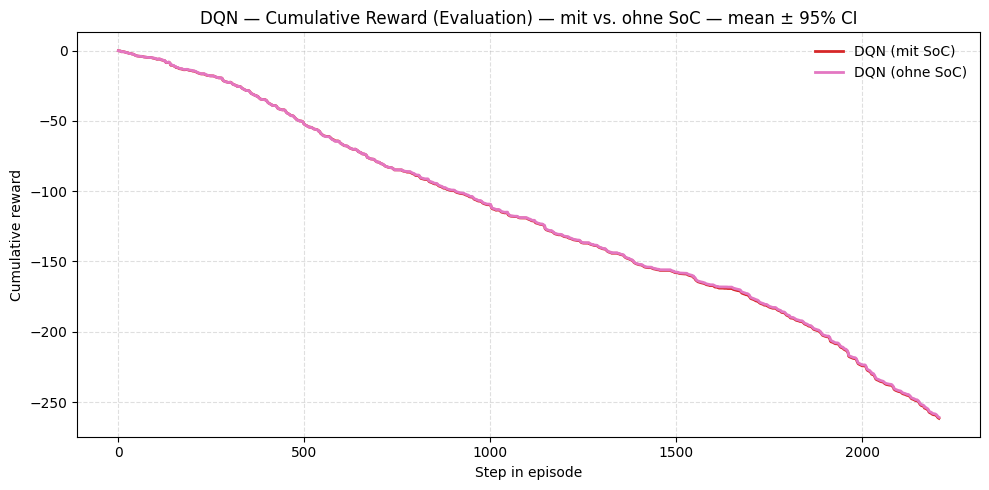

/scratch/slurm_tmpdir/job_1547148/ipykernel_584110/2547240291.py:49: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data, labels=labels, showfliers=False, patch_artist=True)


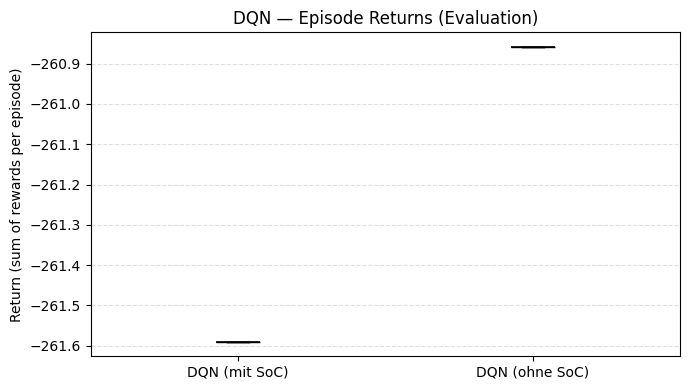

DQN (mit SoC)   : mean=-261.589, std=0.000, n=10
DQN (ohne SoC)  : mean=-260.859, std=0.000, n=10


In [2]:
# ----- DQN: normal vs. without SoC -----

DQN_EVAL_FILE_BASE   = DQN_EVAL_FILE  
DQN_EVAL_FILE_NOSOC  = r'/hkfs/home/haicore/iai/cj9272/logs/dqn/dqn_eval_10episodes_1seed_without_soc.pkl'

COLOR_BASE  = "C3"  
COLOR_NOSOC = "C6"  

eps_base  = all_episode_step_rewards_from_pkl(DQN_EVAL_FILE_BASE)
eps_nosoc = all_episode_step_rewards_from_pkl(DQN_EVAL_FILE_NOSOC)

# mean ± 95% CI der kumulativen Rewards (auf min-Länge getrimmt)
mc_base   = mean_ci_cumcurves(eps_base)
mc_nosoc  = mean_ci_cumcurves(eps_nosoc)
if mc_base is None or mc_nosoc is None:
    raise ValueError("Keine Episoden gefunden in einem der DQN-Eval-Files.")
mean_base, ci_base   = mc_base
mean_nosoc, ci_nosoc = mc_nosoc

x_base  = np.arange(len(mean_base))
x_nosoc = np.arange(len(mean_nosoc))

# ---- Plot 1: cumulative reward (mean ± 95% CI) ----
plt.figure(figsize=(10,5))
plt.plot(x_base,  mean_base,  lw=2, color=COLOR_BASE,  label="DQN (mit SoC)")
if ci_base is not None and np.any(ci_base):
    plt.fill_between(x_base, mean_base-ci_base, mean_base+ci_base, alpha=0.15, linewidth=0, color=COLOR_BASE)

plt.plot(x_nosoc, mean_nosoc, lw=2, color=COLOR_NOSOC, label="DQN (ohne SoC)")
if ci_nosoc is not None and np.any(ci_nosoc):
    plt.fill_between(x_nosoc, mean_nosoc-ci_nosoc, mean_nosoc+ci_nosoc, alpha=0.15, linewidth=0, color=COLOR_NOSOC)

plt.xlabel("Step in episode")
plt.ylabel("Cumulative reward")
plt.title("DQN — Cumulative Reward (Evaluation) — mit vs. ohne SoC — mean ± 95% CI")
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend(frameon=False)
plt.tight_layout()
plt.show()

# ---- Plot 2: Episode-Returns (Boxplot) ----
ret_base  = episode_returns(eps_base)
ret_nosoc = episode_returns(eps_nosoc)

fig, ax = plt.subplots(figsize=(7,4))
data   = [ret_base, ret_nosoc]
labels = ["DQN (mit SoC)", "DQN (ohne SoC)"]
colors = [COLOR_BASE, COLOR_NOSOC]
bp = ax.boxplot(data, labels=labels, showfliers=False, patch_artist=True)
for patch, c in zip(bp['boxes'], colors):
    patch.set_facecolor(c)
for med in bp['medians']:
    med.set_color('black'); med.set_linewidth(1.2)
ax.set_title("DQN — Episode Returns (Evaluation)")
ax.set_ylabel("Return (sum of rewards per episode)")
ax.grid(True, axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

print(f"DQN (mit SoC)   : mean={ret_base.mean():.3f}, std={ret_base.std(ddof=1):.3f}, n={ret_base.size}")
print(f"DQN (ohne SoC)  : mean={ret_nosoc.mean():.3f}, std={ret_nosoc.std(ddof=1):.3f}, n={ret_nosoc.size}")